# This notebook is to implement the patch-based optimization to solve the spatial variant problem

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import torch
import os
import signal
import cv2
import scipy.io as sio
import scipy
import imageio
import time
import skimage as sk
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import display, clear_output

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
from opticaltomography.forward_3dri import PhaseObject3D, TomographySolver
from opticaltomography.loss import mse_loss, sparsity_loss, total_variation_loss_2d, mse_loss_np
import opticaltomography.opticsutils_3dri as utils
from opticaltomography.opticsutils_3dri import norm, norm_np, find_min_index, compute_psf_matrix_row

In [3]:
import opticaltomography.opticsutils_3dri

# The varying trend of the PSF

In [3]:
predict_psf_meas = np.load('Result/predict_psf_usaf_100x100.npy')

In [4]:
predict_psf_meas.shape

(10000, 200, 200)

In [5]:
predict_psf_meas = predict_psf_meas.reshape((100,100,200,200))

In [6]:
# Normalize the PSFs
predict_psf_meas /= np.max(predict_psf_meas, axis=(2, 3), keepdims=True)

In [31]:
center_psf = predict_psf_meas[50,50,:,:]
# plt.figure()
# plt.imshow(center_psf)
mse_list = []
cc_list = []

In [ ]:
for i in range(50):
    print(i)
    mse_list.append(mse_loss_np(np.roll(predict_psf_meas[50+i,50,:,:], shift=-i, axis=1), center_psf))
    cc_list.append(scipy.signal.correlate2d(np.roll(predict_psf_meas[50+i,50,:,:], shift=-i, axis=1), center_psf, mode='same'))

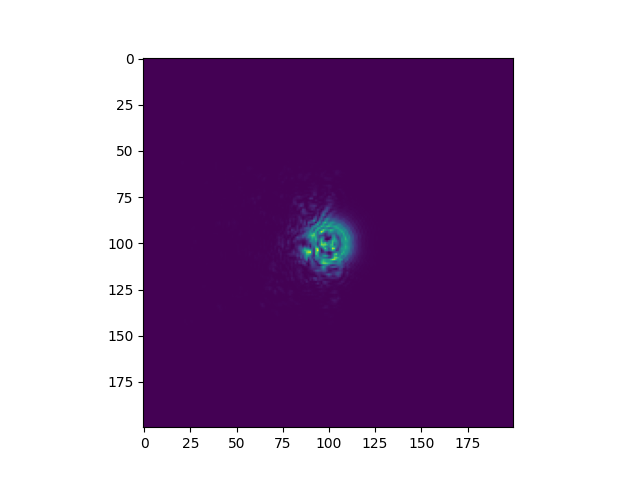

In [8]:
plt.figure()
plt.imshow(np.roll(predict_psf_meas[90,50,:,:], shift=-40, axis=1))

In [ ]:
plt.figure()
plt.imshow(center_psf)

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

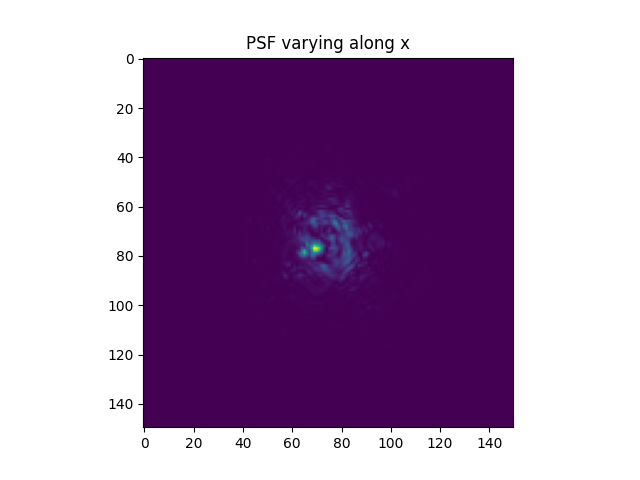

In [10]:
# Imshow ground truth object
f, axes = plt.subplots()
frames = []


def init():
    frames.append(axes.imshow(predict_psf_meas[50,50,25:175,25:175]))
    axes.set_title('PSF varying along x')

init()

def updateFrames(i):
    frames[0].set_data(predict_psf_meas[50+i,50,25:175,25:175])

interact(updateFrames, i=IntSlider(min=0, max=49, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.updateFrames(i)>

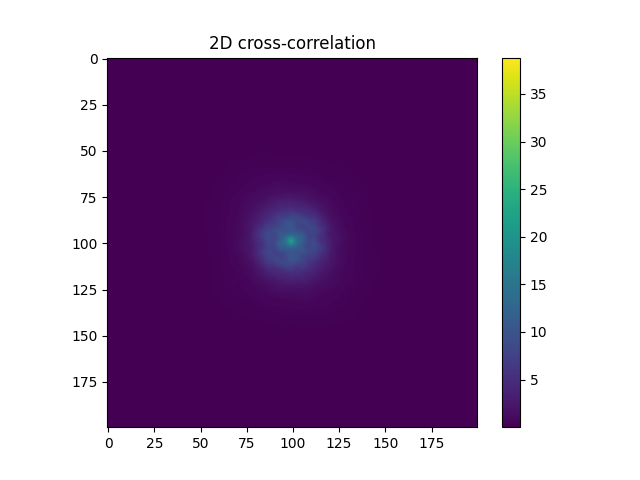

In [40]:
# Imshow ground truth object
f, axes = plt.subplots()
frames = []


def init():
    im_obj = axes.imshow(cc_list[i])
    frames.append(im_obj)
    f.colorbar(im_obj, ax=axes)
    axes.set_title('2D cross-correlation')

init()

def updateFrames(i):
    frames[0].set_data(cc_list[i])

interact(updateFrames, i=IntSlider(min=0, max=49, step=1, value=0))

In [41]:
images = []

for i in range(50):
    img = np.array(norm_np(cc_list[i]))*255
    images.append(img.astype(np.uint8))

imageio.mimsave('Result/patch_bsed/cc_PSF_varying_x.gif', images, duration=0.2)

Text(0, 0.5, 'MSE loss')

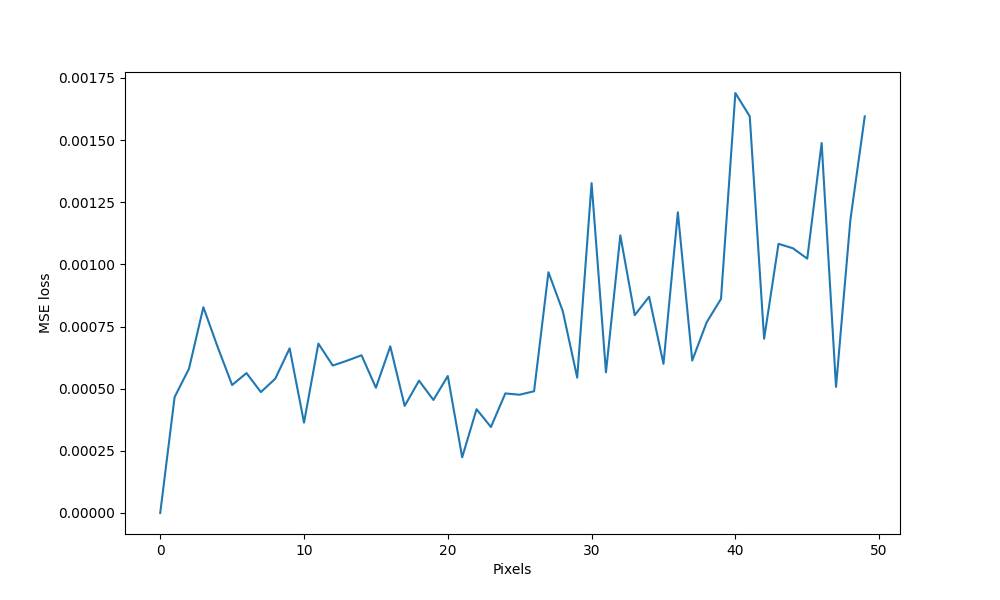

In [39]:
plt.figure(figsize=(10,6))
plt.plot(mse_list)
plt.xlabel('Pixels')
plt.ylabel('MSE loss')

# Compute the Patch-wise PSF convolution

In [4]:
predict_psf_meas_origin = np.load('Result/predict_psf_usaf_100x100.npy')
predict_psf_meas = predict_psf_meas_origin.reshape((100,100,200,200))
#predict_psf_meas /= np.max(predict_psf_meas, axis=(2, 3), keepdims=True)

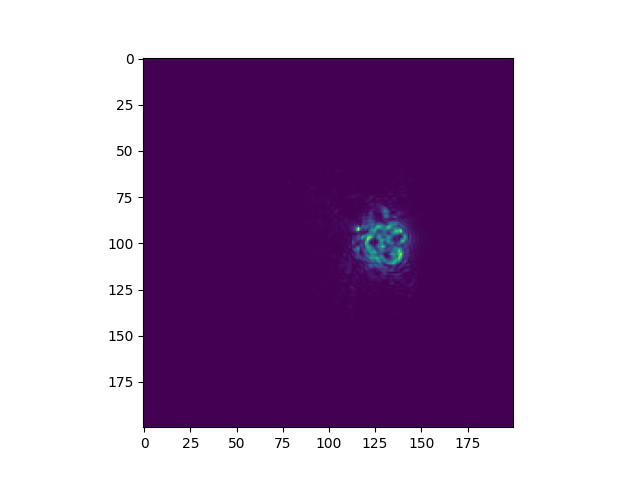

In [8]:
plt.figure()
plt.imshow(predict_psf_meas[80,50,:,:])

In [5]:
# patch_block = 4
# patch_position = 0 (1,2,3)
patch_psf = np.zeros((50,50,80,80))

In [6]:
predict_psf_meas.shape

(100, 100, 200, 200)

In [6]:
for i in range(50):
    for j in range(50):
        patch_psf[j,i] = np.roll(predict_psf_meas[i*2,j*2], shift=(50-i*2, 50-j*2), axis=(1,0))[60:140,60:140]
        # patch_psf[j,i] = np.roll(predict_psf_meas[i*2,j*2], shift=(0, 0), axis=(1,0))

In [5]:
patch_psf = np.zeros((100,100,80,80))
for i in range(100):
    for j in range(100):
        patch_psf[j,i] = np.roll(predict_psf_meas[i,j], shift=(50-i, 50-j), axis=(1,0))[60:140,60:140]

In [9]:
patch_psf_comp, psf_index = opticaltomography.opticsutils_3dri.patch_matrix(patch_psf, 50, 80, 1)

In [ ]:
# Imshow ground truth object
f, axes = plt.subplots()
frames = []


def init():
    im_obj = axes.imshow(patch_psf[0,0])
    frames.append(im_obj)
    f.colorbar(im_obj, ax=axes)

init()

def updateFrames(i):
    x = i%50
    y = (i-i%50)//50
    frames[0].set_data(patch_psf[x,y])

interact(updateFrames, i=IntSlider(min=0, max=2499, step=1, value=0))

# Solve the inverse problem with direct patch-wise convolution

### Load the settings

Text(0.5, 1.0, 'GT USAF target')

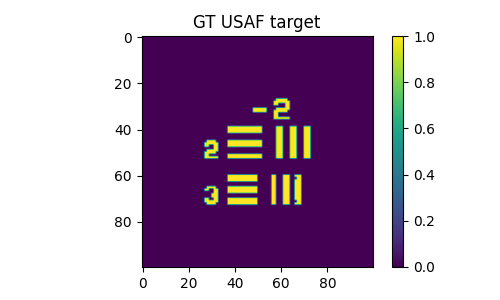

In [7]:
usaf = np.array(plt.imread('Dataset/usaf_s.jpeg'))
usaf = sk.color.rgb2gray(cv2.resize(usaf, (50, 50)))
usaf = np.where(usaf > 0.8, 1, 0)
usaf = np.pad(usaf, ((75, 75), (75, 75)), mode='constant', constant_values=0)
plt.figure(figsize=(5, 3))
plt.imshow(usaf[50:150, 50:150])
plt.colorbar()
plt.title('GT USAF target')

In [8]:
# compute forward wide-field measurement
psf_matrix, psf_matrix_truncate, row_return = utils.PSF_matrix(predict_psf_meas_origin, ymin=50, ymax=150, xmin=50, xmax=150, shape=(200,200))
usaf_vec = usaf.reshape((-1,))
meas = norm_np(np.matmul(psf_matrix, usaf_vec).reshape((200,200)))

In [8]:
meas = np.load('Result/meas.npy')

In [26]:
# Units in um
wavelength = 0.519  # emission wl excited by 488 nm
n_measure = 1.33    # n of water
n_b = 1.33          # background
mag = 20            # 20x mag
pixel_size = 6.5    # pixel size = 6.5 um * 6.5 um      
na = 0.45
dx = pixel_size / mag  # pixel size = 6.5 um -> pixel size at the sample plane: 6.5 / 20 um
dy = dx
dz = dx * 3

t_f32 = torch.float32
t_c64 = torch.complex64
np_f32 = np.float32
np_c64 = np.complex64

In [27]:
dir = "Dataset/"
mat_name = 'na_list_3D_rand_10.mat'
na_list = sio.loadmat(dir+mat_name)
fx_illu_list = na_list["na_list_3D_rand"][:, 0] * 3    # paraxial condition
fy_illu_list = na_list["na_list_3D_rand"][:, 1] * 3
fz_illu_list = na_list["na_list_3D_rand"][:, 2] * 0      # z layer at the z = 0 / 2D sample

In [12]:
# initial object, type: torch.float32
phantom = torch.zeros((200, 200, 25), dtype=t_f32)

In [12]:
# Set up ground truth object
phantom_coordinates = sio.loadmat("Dataset/phantomPoisson_nooverlap.mat")
phantom_temp = phantom_coordinates["phantomPoisson"]
phantom_obj = torch.ones_like(phantom) * 1.33 # set background
phantom_obj[50:150, 50:150, :] = phantom_obj[50:150, 50:150, :] + torch.from_numpy(phantom_temp) * 0.05 # ground truth
#solver_obj._x[50:150, 50:150, :] = torch.from_numpy(phantom_temp) * 0.1 # ground truth

In [13]:
solver_params = dict(wavelength = wavelength, na = na, \
                     RI_measure = n_measure, sigma = 2 * np.pi * dz / wavelength,\
                     fx_illu_list = fx_illu_list, fy_illu_list = fy_illu_list, fz_illu_list = fz_illu_list, \
                     voxel_size=(dy,dx,dz), pad = False, pad_size=(50,50))
phase_obj_3d = PhaseObject3D(shape=phantom.shape, voxel_size=(dy,dx,dz), RI_obj=phantom_obj, RI=n_b) # set phantom_obj as gt obj, n_b as background
solver_obj = TomographySolver(phase_obj_3d=phase_obj_3d, **solver_params)
solver_obj.setScatteringMethod(model="MultiPhaseContrast")  # select scattering model

### Solve inverse problem with optimization

In [9]:
# Set GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device_no = 0
torch.cuda.set_device(device_no)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
torch.cuda.get_device_name()

'NVIDIA TITAN Xp'

In [11]:
recon_obj = torch.zeros((200,200), requires_grad=True, device=device)
patch_psf_tensor = torch.tensor(patch_psf, device=device)
usaf_tensor = torch.tensor(usaf, device=device)
meas_tensor = torch.tensor(meas, device=device)
# pred_forward = torch.zeros((200,200), device=device)
# inter_result = torch.zeros((80,80), device=device)

In [12]:
# Set parameters

n_iters = 100
learning_rate = 0.01

optimizer = torch.optim.Adam([recon_obj], lr=learning_rate)
# optimizer = torch.optim.SGD([recon_obj], lr=learning_rate, momentum=0.9)

losslist = []

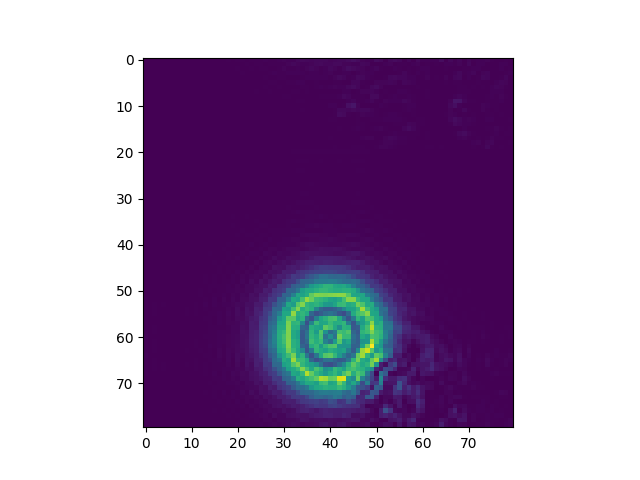

In [22]:
plt.figure()
plt.imshow(np.roll(patch_psf[0,0],(20,0),axis=(0,1)))

In [13]:
def patch_convolution(recon_obj, patch_psf, device=device):
    # patch gap = 2
    # inter_result = torch.zeros((81,81), device=device)
    pred_forward = torch.zeros((200,200), device=device)
    for i in range(50):
        for j in range(50):
            for yy in range(2):
                for xx in range(2):
                    pred_forward[(10+yy+i*2):(90+yy+i*2),(10+xx+j*2):(90+xx+j*2)] = pred_forward[(10+yy+i*2):(90+yy+i*2),(10+xx+j*2):(90+xx+j*2)] + recon_obj[50+yy+2*i,50+xx+2*j]*patch_psf[i,j]
            
    return pred_forward

In [13]:
def patch_convolution_100(recon_obj, patch_psf, device=device):
    # patch gap = 2
    inter_result = torch.zeros((80,80), device=device)
    pred_forward = torch.zeros((200,200), device=device)
    for i in range(100):
        for j in range(100):
            inter_result = recon_obj[50+i,50+j]*patch_psf[i,j]
            
            pred_forward[(10+i):(90+i),(10+j):(90+j)] = pred_forward[(10+i):(90+i),(10+j):(90+j)] + inter_result
            
    return pred_forward

In [ ]:
plt.figure()
plt.imshow(pred_forward)

In [13]:
for epoch in range(n_iters):
    loss = 0
    optimizer.zero_grad()
    pred_forward = utils.patch_interp_conv22(recon_obj, patch_psf_tensor, device=device)
    
    loss = mse_loss(pred_forward, meas_tensor) + total_variation_loss_2d(pred_forward, 50, device=device)
    # + total_variation_loss_2d(pred_forward, 1, device=device)
    
    losslist.append(loss)
    
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        print(f'Reconstruction after iteration {epoch}, loss {loss:.4e}')

Reconstruction after iteration 0, loss 1.9289e-02
Reconstruction after iteration 1, loss 1.4144e-02
Reconstruction after iteration 2, loss 1.0534e-02
Reconstruction after iteration 3, loss 7.8013e-03
Reconstruction after iteration 4, loss 5.7476e-03
Reconstruction after iteration 5, loss 4.2707e-03
Reconstruction after iteration 6, loss 3.2607e-03
Reconstruction after iteration 7, loss 2.6040e-03
Reconstruction after iteration 8, loss 2.2011e-03
Reconstruction after iteration 9, loss 1.9705e-03
Reconstruction after iteration 10, loss 1.8488e-03
Reconstruction after iteration 11, loss 1.7893e-03
Reconstruction after iteration 12, loss 1.7583e-03
Reconstruction after iteration 13, loss 1.7321e-03
Reconstruction after iteration 14, loss 1.6949e-03
Reconstruction after iteration 15, loss 1.6377e-03
Reconstruction after iteration 16, loss 1.5564e-03
Reconstruction after iteration 17, loss 1.4512e-03
Reconstruction after iteration 18, loss 1.3270e-03
Reconstruction after iteration 19, loss 1

KeyboardInterrupt: 

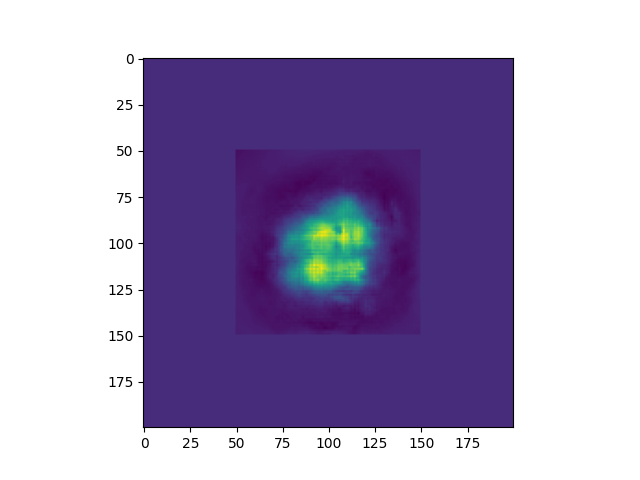

In [17]:
plt.figure()
plt.imshow(recon_obj.detach().cpu())

In [ ]:
np.save('Result/patch_bsed/patch_1_tv10_epoch2000.npy',recon_obj.detach().cpu())

In [ ]:
losslist_cpu = [tensor.detach().cpu() for tensor in losslist]
np.save('Result/patch_bsed/patch_1_loss_tv10_epoch2000.npy',losslist_cpu)

In [ ]:
psnr_value = psnr(np.array(recon_obj.detach().cpu()[50:150,50:150]).astype(np.float64), usaf[50:150, 50:150].astype(np.float64))
print(psnr_value)
# Compute SSIM (Structural Similarity Index)
ssim_value = ssim(np.array(recon_obj.detach().cpu()[50:150, 50:150]).astype(np.float64), usaf[50:150, 50:150].astype(np.float64))
print(ssim_value)

In [59]:
pred_forward.device

device(type='cpu')

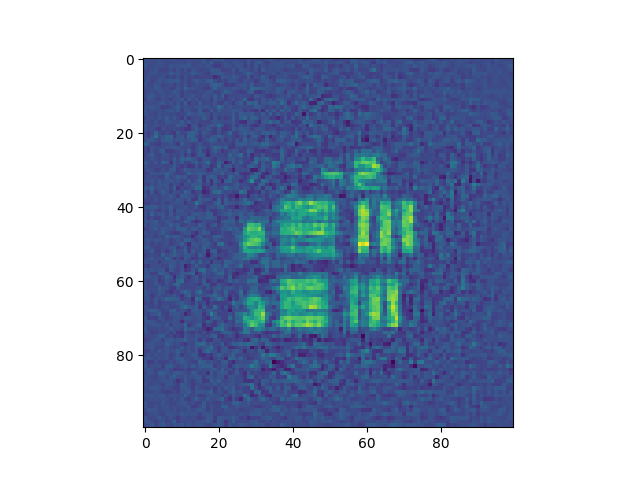

In [16]:
a = np.load('Result/patch_bsed/patch_1_tv10_epoch1000.npy')
plt.figure()
plt.imshow(a[50:150,50:150])

In [17]:
psnr_value = psnr(np.array(a[50:150,50:150].astype(np.float64)), usaf[50:150, 50:150].astype(np.float64))
print(psnr_value)
# Compute SSIM (Structural Similarity Index)
ssim_value = ssim(np.array(a[50:150,50:150].astype(np.float64)), usaf[50:150, 50:150].astype(np.float64))
print(ssim_value)

20.617453808620958
0.6675187884903466


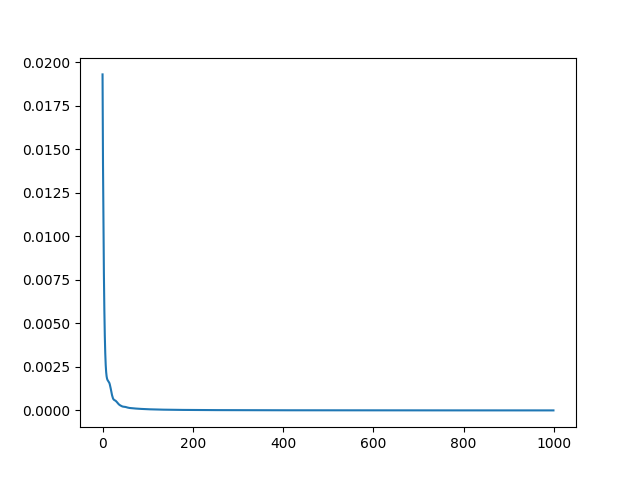

In [8]:
b = np.load('Result/patch_bsed/patch_1_loss_tv10_epoch1000.npy')
plt.figure()
plt.plot(b)

In [19]:
b[-2]

2.9540967315205974e-06